# Travelling Salesman Problem
## Assignment 3
### Stochastic Simulation

#### Authors
| Name 	| UvaNetID 	| Email 	|
|---	|---	|---	|
| Jasper Timmer 	| 12854328 	| jasper.m.timmer@student.uva.nl 	|
| Juan Sandalinas 	| 15269338 | juan.sandalinas.viladevall@student.uva.nl |
| Pablo Alves 	    | 15310191  | pablo.rodriguez.alves@student.uva.nl 	|


#### Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#### File handling functions

In [8]:
def load_tsp_file(file_path):
    """ Loads the (x,y) coordinates for the TSP problem from a txt
    as a dictionary """

    tsp_data = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate the start of the NODE_COORD_SECTION
    start_loading = False

    for line in lines:
        # Strip leading and trailing whitespaces
        line = line.strip()

        # Check for the start of the NODE_COORD_SECTION
        if line == "NODE_COORD_SECTION":
            start_loading = True
            continue

        # Check for the end of the file
        if line == "EOF":
            break

        if start_loading:
            parts = line.split()
            
            # Extract node number, x-coordinate, and y-coordinate
            node_number = int(parts[0])
            x_coordinate = float(parts[1])
            y_coordinate = float(parts[2])

            # Store data in the dictionary
            tsp_data[node_number] = np.array([x_coordinate, y_coordinate])

    # Check if the dataset is as intuitive as it appears
    nodes = set(tsp_data.keys())
    highest_number = max(nodes)
    missing_nodes = set(range(1, highest_number + 1)) - nodes

    if missing_nodes:
        print(f"Note that not all numbers between 0 and {highest_number} are used as a node ID. Node(s) {missing_nodes} are missing.")

    return tsp_data


def load_optimal_tsp_file(file_path):
    """ Loads the best route for the TSP problem
    and returns it as a np array"""
    
    tsp_data = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate the start of the TOUR_SECTION
    start_loading = False

    for line in lines:
        # Strip leading and trailing whitespaces
        line = line.strip()

        # Check for the start of the TOUR_SECTION
        if line == "TOUR_SECTION":
            start_loading = True
            continue

        # Check for the end of the file
        # NEW! We now end at -1 to avoid adding extra elements to the route
        if line == "-1":
            break

        if start_loading:
            tsp_data.append(int(line))

    return np.array(tsp_data)


def is_solution_optimal(solution,optimal):
    """ Returns true if two np arrays are equal element-wise,
    used for comparing against the optimal solution """
    return np.array_equal(solution,optimal)

#### Helper functions

In [9]:
def generate_solution(tsp_data):
    """ Creates a random order TSP route as starting guess """
    return np.random.permutation(list(tsp_data.keys()))

In [10]:
def get_score(tsp_data, solution):
    """ Computes the associated score of a TSP solution
    using standard 2D Euclidean distance """
    distance = 0
    coordinates = solution[0]
    for city in solution[1:]:
        next_coordinates = tsp_data[city]
        distance += np.linalg.norm(coordinates - next_coordinates)
        coordinates = next_coordinates.copy()

    return distance

#### Optimization Algorithms

In [11]:
def swap(solution):
    # Randomly choose two distinct indices
    indices = np.random.choice(len(solution), size=2, replace=False)

    new_solution = solution[:]

    # Swap the elements at the selected indices
    new_solution[indices[0]], new_solution[indices[1]] = new_solution[indices[1]], new_solution[indices[0]]

    return new_solution

In [12]:
def hillclimber(current_score, new_score, parameters):
    # Hillclimber function, accept only better scores
    return current_score > new_score

In [13]:
def simulated_annealing(current_score, new_score, T):
    return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)

In [14]:
def insert(solution):
    n = len(solution)

    # Choose two distinct indices for the insertion
    source_index, dest_index = np.random.choice(n, size=2, replace=False)

    # Ensure source_index is before dest_index
    source_index, dest_index = min(source_index, dest_index), max(source_index, dest_index)

    # Perform insertion
    moved_element = solution[source_index]
    new_solution = np.delete(solution, source_index)
    new_solution = np.insert(new_solution, dest_index, moved_element)

    return new_solution

In [15]:
# TODO: 'scramble mutation'

In [16]:
def inversion(solution):
    n = len(solution)

    # Choose two distinct indices for the inversion
    start, end = np.random.choice(n, size=2, replace=False)
    start, end = min(start, end), max(start, end)

    # Perform inversion
    new_solution = solution[:]
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    return new_solution

In [17]:
# TODO: - '2-opt','3-opt', 'or-opt'

In [18]:
# TODO: 'Lin-Kernighan'

In [19]:
# TODO: More cooling schemes like geometrical/linear cooling, or arithmetic-geometric cooling

def log_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    return cooling_parameters['c'] / np.log(1 + i)

#### Optimizing functions

In [20]:
def optimize(start_solution, tsp_data, iterations, mutate, accept, cooling_schedule=log_cool, cooling_parameters={'c':1}):
    """
    Optimize solution for traveling salesman problem according to chosen mutate and accept function
    """ 

    solution = start_solution[:]
    current_score = get_score(tsp_data, solution)

    Ts = cooling_schedule(iterations, cooling_parameters)

    # Do iterations
    for i in range(iterations):

        # Make new solution via chosen mutation function
        new_solution = mutate(solution)
        new_score = get_score(tsp_data, new_solution)

        # Accept or deny new solution according to chosen acceptance function and corresponding parameters
        if accept(current_score, new_score, Ts[i]):
            solution = new_solution[:]
            current_score = new_score

    return solution, current_score

In [21]:
# Keep track of scores across iterations
def optimize_log(start_solution, tsp_data, iterations, mutate, accept, cooling_schedule=log_cool, cooling_parameters={'c':1}):
    """
    Optimize solution for traveling salesman problem according to chosen mutate and accept function,
    keeping track of the scores of each iteration
    """ 

    scores = np.zeros(iterations)
    solution = start_solution[:]
    current_score = get_score(tsp_data, solution)

    Ts = cooling_schedule(iterations, cooling_parameters)
    
    # Do iterations
    for i in range(iterations):

        # Make new solution via chosen mutation function
        new_solution = mutate(solution)
        new_score = get_score(tsp_data, new_solution)
        
        # New!
        scores[i] = new_score

        # Accept or deny new solution according to chosen acceptance function and corresponding parameters
        if accept(current_score, new_score, Ts[i]):
            solution = new_solution[:]
            current_score = new_score

    return solution, current_score, scores

#### Test 0. Basic simulation

In [22]:
# Load data for 51 location TSP
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)

# Also load optimal solution
file_path = f'TSP-Configurations/{file}.opt.tour.txt'
optimal_tsp_route = load_optimal_tsp_file(file_path)

# Get starting solution
start_solution = generate_solution(tsp_data)

iterations = 200000

# swap, insert or inversion
mutate = swap

# hillclimber or simulated_annealing
accept = hillclimber

parameters = {}
best_solution, score = optimize(start_solution, tsp_data, iterations, mutate, accept, **parameters)

# Compare best solution to optimal solution of txt file
OPTIMAL_SOLUTION_FOUND = is_solution_optimal(best_solution,optimal_tsp_route)

print('Best solution',best_solution)
print('Score',score)
print()
print('Is it the optimal?',OPTIMAL_SOLUTION_FOUND)
print('Optimal solution score',get_score(tsp_data, optimal_tsp_route))

C:\Users\jaspe\AppData\Local\Temp\ipykernel_47096\2994896465.py:5: RuntimeWarning: divide by zero encountered in divide
  return cooling_parameters['c'] / np.log(1 + i)


Best solution [18 50 41 39 30 19 34 20 11 14 44 15 16 28 23 12 47 49 46 40  4  6 32 25
 36  3 38  2 13 48 42 10 35 33  7 21 37 17 45  9 31  8  1 27  5 22 51 43
 29 26 24]
Score 1221.0800547204728

Is it the optimal? False
Optimal solution score 486.23409243906286


### Test 1. Score evolution vs. iterations
With optimal score plot 

In [23]:
# 1. Computation

# Parameters
iterations = 200000

# swap, insert or inversion
mutate = swap

# hillclimber or simulated_annealing
accept = hillclimber

parameters = {}

# Load data
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)

# Get starting solution
start_solution = generate_solution(tsp_data)

# Optimize TSP
best_solution, score, scores = optimize_log(start_solution, tsp_data, iterations, mutate, accept, **parameters)


C:\Users\jaspe\AppData\Local\Temp\ipykernel_47096\2994896465.py:5: RuntimeWarning: divide by zero encountered in divide
  return cooling_parameters['c'] / np.log(1 + i)


In [24]:
# Load optimal solution for comparisson
file_path = f'TSP-Configurations/{file}.opt.tour.txt'
optimal_tsp_route = load_optimal_tsp_file(file_path)

OPTIMAL_SOLUTION_FOUND = is_solution_optimal(best_solution,optimal_tsp_route)

In [25]:
# 2. Printing
print('Best solution:')
print('Score:',score)
print(best_solution)
print()
print('Is it optimal?',OPTIMAL_SOLUTION_FOUND)
print('Score',get_score(tsp_data, optimal_tsp_route))

Best solution:
Score: 1213.5962846392247
[31 33 37 14 17 44 49 27 46 30 32  7 16  1  9 47 39 48 50 36 41 26 43 40
 19  8 25 21 13  6  2 20 23 34 11 18 12 29 35 15  5 45  4 10 22 51 28  3
 42 38 24]

Is it optimal? False
Score 486.23409243906286


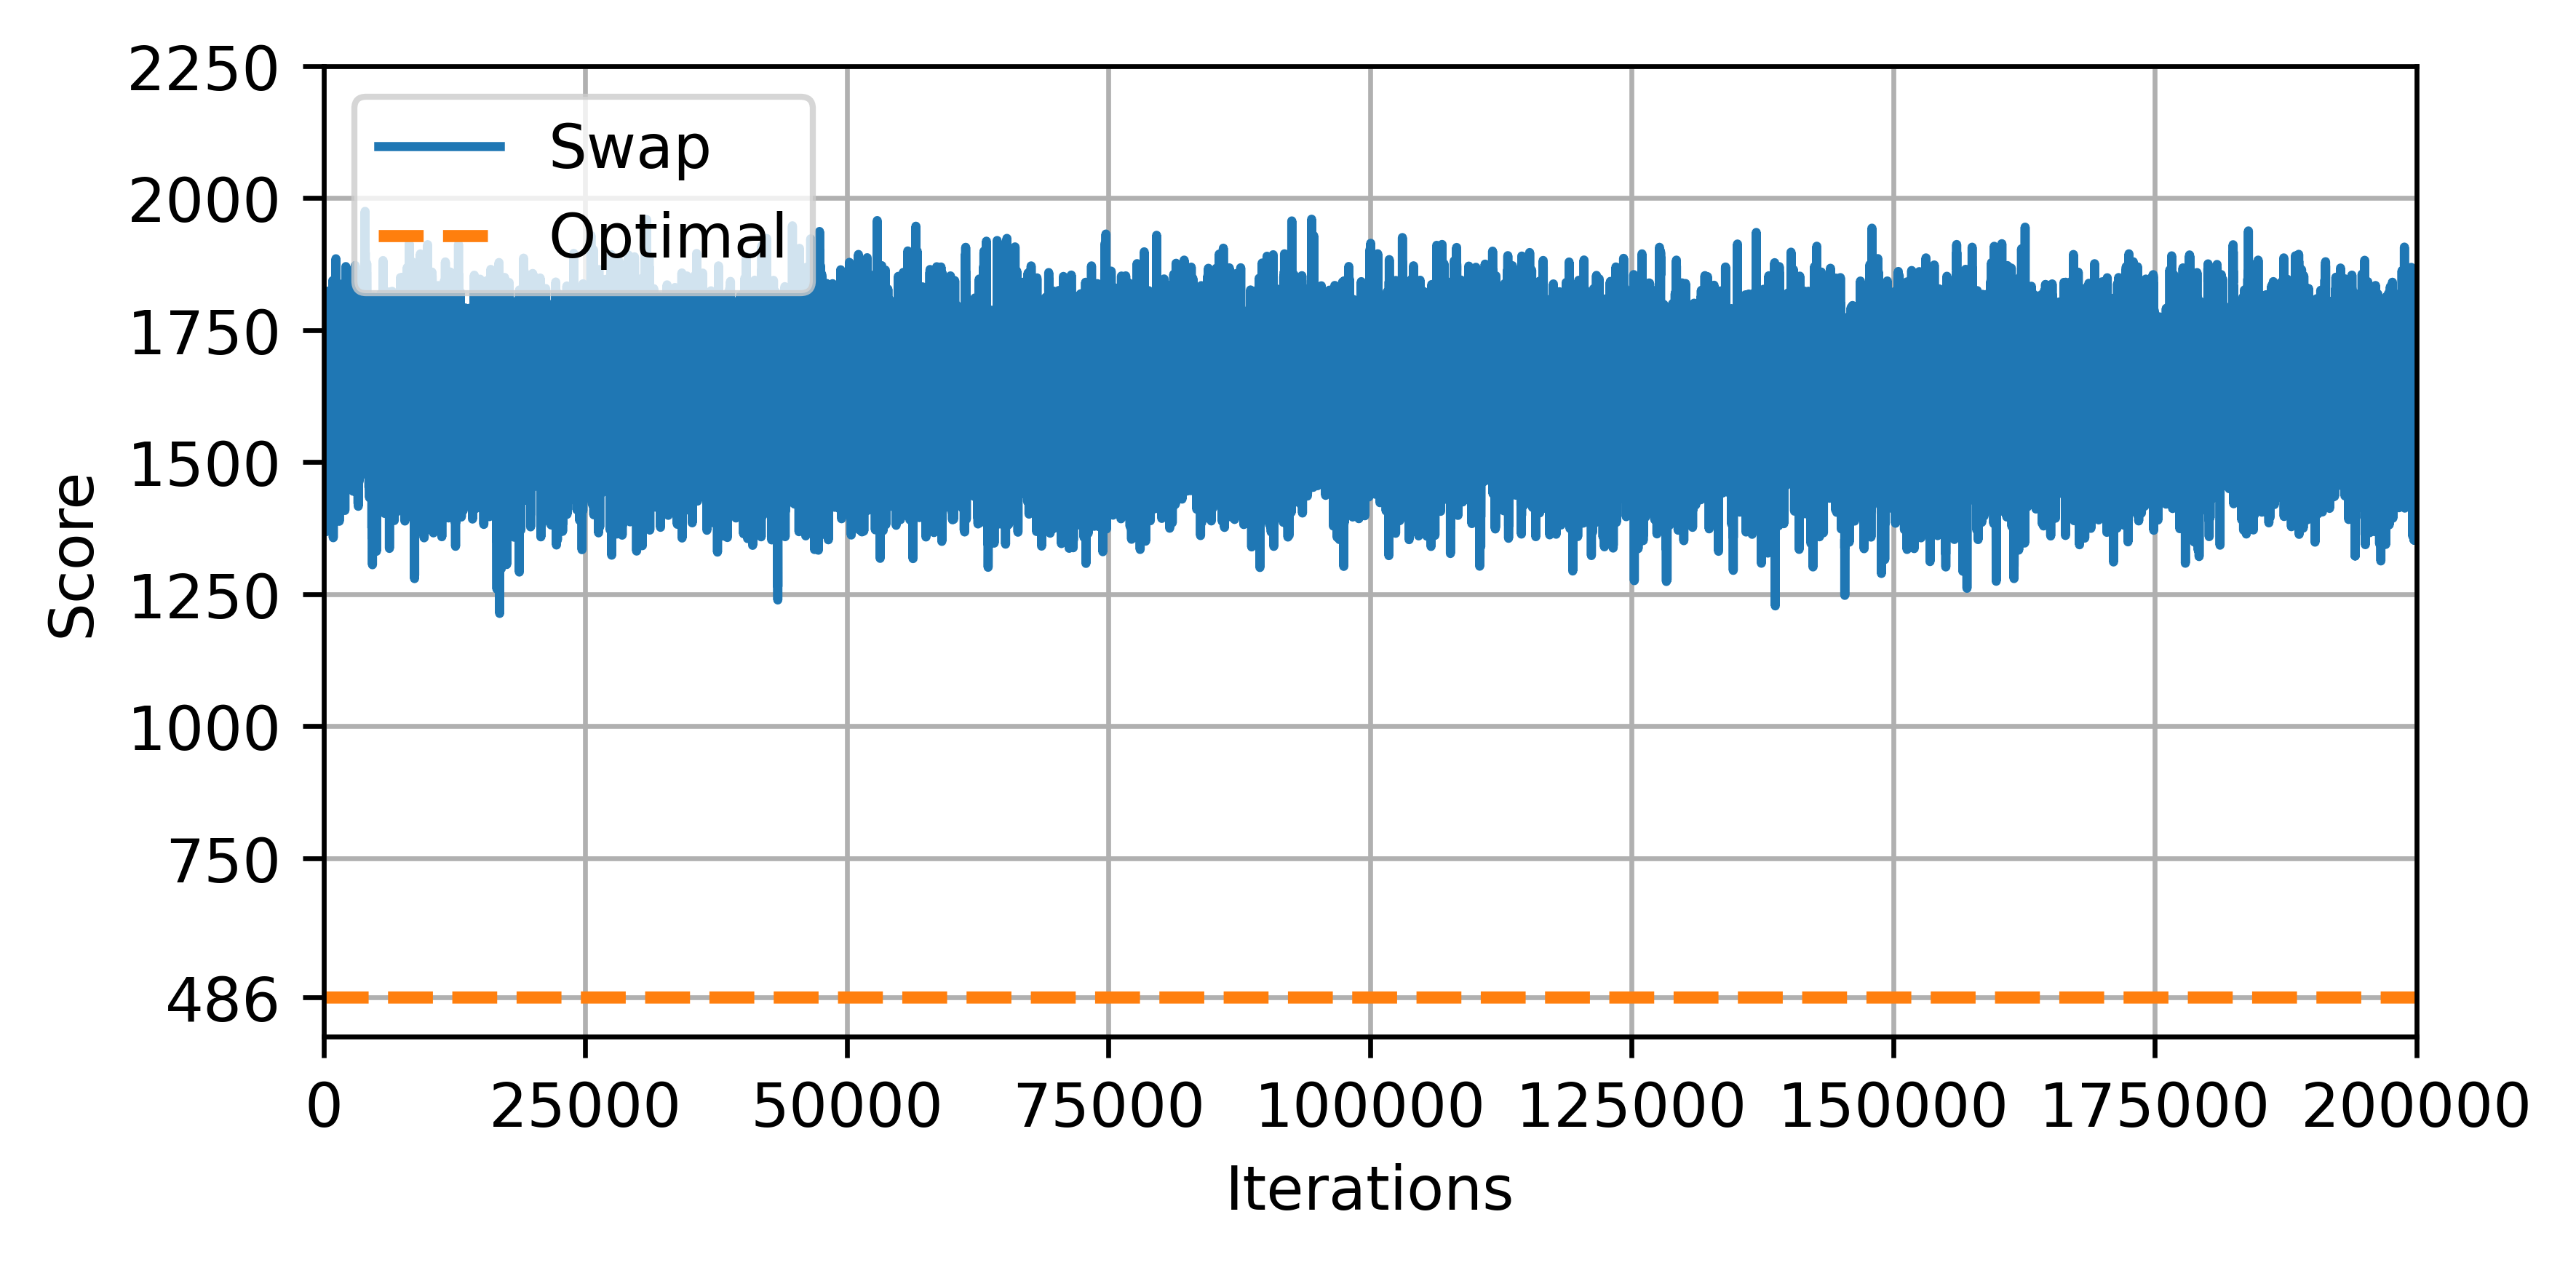

In [26]:
# 3. Plotting

# Create plot
plt.figure(figsize=(6,3),dpi=600)

# Plot score
plt.plot(range(iterations),scores,label='Swap')

# Plot optimal score
optimal_score = get_score(tsp_data, optimal_tsp_route)
plt.plot(range(iterations),np.ones(iterations)*optimal_score,'--',label='Optimal',linewidth=2)

plt.xlabel('Iterations')
plt.ylabel('Score')

# Add optimal score as a ytick and lower ylim
# May need to remove first yticks mannualy like this:
# plt.yticks(list(plt.yticks()[0][2:]) + [optimal_score])
plt.yticks(list(plt.yticks()[0][2:]) + [optimal_score])
#plt.ylim([optimal_score, plt.ylim()[-1]])

plt.xlim([0, iterations])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


### Test 2. Perform many simulations for same method
- Change previous code
- Get confidence intervals
- Plotting
- Save results

In [27]:
# TODO

### Test 3. Perform many simulations for all the methods
- At least the three bad methods we are told about: 2-opt, swapping, moving one node
- Get confidence intervals
- Plotting: one plot with many methods and confidence levels: nice :)
- Save results

In [28]:
# TODO

### Test 4. [IMPORTANT] Implement Simulated Annealing Method
- Ensure you converge to a good local minimum
- Try different cooling schedules and observe their effect on convergence
- Study effect of Markov Chain's length on convergence

In [29]:
# TODO

### Test 5. [IMPORTANT] Implement stat testing
- Multiple things
- Also use to justify parameters
- We can time execution times, show how they increase with $n$ etc...
- We can also and should estimate average score after random initialization (by doing several random initializations)
- Add ideas for tests here
- Conduct the tests here too!


**Ideas for tests** 
- [X] Prob. of reaching optimal route after X iterations is P.
- [ ] Probability of score getting X close to optimal
- [ ] Convergence time increases with $n$ exponentially



In [30]:
# TODO

### Test 6. Scale to a280.tsp data
- It's the one the assignment should focus on

In [31]:
# TODO